---
title: "Build models"
execute:
  echo: true
  enabled: false
  output: true
  warning: false
---

In [1]:
#| echo: false
#| output: false
basepath = "/home/root/"

In [2]:
#| echo: false
#| output: false
import os
os.environ["MODIN_ENGINE"] = "dask"
import modin.pandas as pd
import numpy as np

pd.set_option("display.max_columns", None)

In [3]:
from detect_common import *

## Build models with different hyperparameters {#sec-build-models}

Models to evaluate:

 - LogisticRegression (only for the baseline)
 - RandomForest
 - HistGradientBoosting

Parameters:

 - Normalization of statistical parameters (hypothesis: should decrease concept drift)
 - Skip of first few packets to decrease TLS handshake influence on classification of DoH
   - Try to apply weights to first few packets for calculation of mean/stdev/variance, instead of just skip
   - Try to skip packets for packet sizes parameters, but don't skip them for inter-packets duration parameters


In [4]:
p1version = "v6"
p2version = "v7"

In [5]:
path_doh_ips = "./doh_resolver_ip.csv"

mix_p = pd.read_feather(f"cached/mixed.p1.{p1version}.saved")

To remove this warning, run the following python code before doing dataframe operations:

    from distributed import Client

    client = Client()

2023-03-22 14:01:40,521 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-cc88cs3u', purging
2023-03-22 14:01:40,522 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-worker-space/worker-ine9p6o8', purging


In [6]:
len(mix_p)

350000

In [7]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    mix_p,
    test_size=0.2,
    random_state=42
)

train.reset_index(drop=True).to_feather(f'cached/mixed.train.p1.{p1version}.saved')
test.reset_index(drop=True).to_feather(f'cached/mixed.test.p1.{p1version}.saved')

Please refer to https://modin.readthedocs.io/en/stable/supported_apis/defaulting_to_pandas.html for explanation.
2023-03-21 22:51:28,930 - distributed.utils_perf - WARNING - full garbage collections took 16% CPU time recently (threshold: 10%)
2023-03-21 22:51:29,926 - distributed.utils_perf - WARNING - full garbage collections took 17% CPU time recently (threshold: 10%)
2023-03-21 22:51:31,075 - distributed.utils_perf - WARNING - full garbage collections took 18% CPU time recently (threshold: 10%)
2023-03-21 22:51:32,366 - distributed.utils_perf - WARNING - full garbage collections took 19% CPU time recently (threshold: 10%)
2023-03-21 22:51:33,642 - distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
2023-03-21 22:51:34,946 - distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
2023-03-21 22:51:35,951 - distributed.utils_perf - WARNING - full garbage collections took 23% CPU time rec

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from joblib import dump, load

train = pd.read_feather(f'cached/mixed.train.p1.{p1version}.saved')

for norm in [True, False]:
    for hyperparam in HYPERPARAMS:
        pp = PreProcessing(norm, *hyperparam)
        name = (
            ('normed-' if norm else 'unnormed-') + 
            '-'.join(str(p) for p in hyperparam)
        )

        print(name)
        clr_lr_file = f'models/LR-mix-1-p-{name}.p1.{p1version}.p2.{p2version}.joblib'
        clf_hgb_file = f'models/HGB-mix-1-p-{name}.p1.{p1version}.p2.{p2version}.joblib'
        clf_rf_file = f'models/RF-mix-1-p-{name}.p1.{p1version}.p2.{p2version}.joblib'

        if any(not os.path.exists(fpath) for fpath in [clr_lr_file, clf_hgb_file, clf_rf_file]):
            full, features, labels = pp.process(train, f"cached/mixed.train.p1.{p1version}.{name}.p2.{p2version}.saved")
            pp.store_scaler(f"cached/mixed.train.p1.{p1version}.{name}.p2.{p2version}.scaler")

            if not os.path.exists(clr_lr_file):
                clf_lr = LogisticRegression(random_state=42, max_iter=200).fit(features, labels)
                dump(clf_lr, clr_lr_file)

            if not os.path.exists(clf_hgb_file):
                clf_hgb = HistGradientBoostingClassifier(random_state=42, max_iter=200).fit(features, labels)
                dump(clf_hgb, clf_hgb_file)

            if not os.path.exists(clf_rf_file):
                clf_rf = RandomForestClassifier(random_state=42).fit(features, labels)
                dump(clf_rf, clf_rf_file)


normed-0-0-0-0
normed-0-4-0-0
normed-1-0-0-0
normed-2-0-0-0
normed-4-0-0-0
normed-6-0-0-0
normed-1-4-0-0
normed-2-0-0-0
normed-2-4-0-0
normed-0-4-0-4
normed-1-0-1-0
normed-2-0-2-0
normed-4-0-4-0
normed-6-0-6-0
normed-1-4-1-4
normed-2-0-2-0
normed-2-4-2-4
unnormed-0-0-0-0
unnormed-0-4-0-0
unnormed-1-0-0-0
unnormed-2-0-0-0
unnormed-4-0-0-0
unnormed-6-0-0-0
unnormed-1-4-0-0
unnormed-2-0-0-0
unnormed-2-4-0-0
unnormed-0-4-0-4
unnormed-1-0-1-0
unnormed-2-0-2-0
unnormed-4-0-4-0
unnormed-6-0-6-0
unnormed-1-4-1-4
unnormed-2-0-2-0
unnormed-2-4-2-4


## Calculate AUC for each model

In [14]:
from sklearn import metrics
import matplotlib.pyplot as plt
from joblib import dump, load

test = pd.read_feather(f'cached/mixed.test.p1.{p1version}.saved')

models = ["LR", "HGB", "RF"]

results = {
    "model": [],
    "normed": [],
    "skips_and_weights": [],
    "test_data_auc": [],
    "fpr": [],
    "tpr": [],
    "thresholds": [],
}

for norm in [True, False]:
    for hyperparam in HYPERPARAMS:
        pp = PreProcessing(norm, *hyperparam)
        name = (
            ('normed-' if norm else 'unnormed-') + 
            '-'.join(str(p) for p in hyperparam)
        )

        print(name)

        full, features, labels = pp.process(test, f"cached/mixed.test.p1.{p1version}.{name}.p2.{p2version}.saved")

        for model in models:
            clf = load(f'models/{model}-mix-1-p-{name}.p1.{p1version}.p2.{p2version}.joblib')

            y_pred = clf.predict_proba(features)[:, 1]
            fpr, tpr, threshold = metrics.roc_curve(labels, y_pred)
            auc = round(metrics.roc_auc_score(labels, y_pred), 4)
            
            results["model"].append(model)
            results["normed"].append(norm)
            results["skips_and_weights"].append(hyperparam)
            results["test_data_auc"].append(auc)
            results["fpr"].append(fpr)
            results["tpr"].append(tpr)
            results["thresholds"].append(threshold)

normed-0-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:44:42,520 - distributed.worker - ERROR - Exception during execution of task lambda-6ddf77a560837fb6bb46aad5018a10f7.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-33d0e9f8-fb4d-435e-80b1-2ac809fe5724'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-0-4-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:45:38,477 - distributed.worker - ERROR - Exception during execution of task lambda-017f054de78f90e57d9d267e47f49277.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-e7af7fb3-9a85-40a0-9319-1d6b81ab6c44'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-1-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:46:37,485 - distributed.worker - ERROR - Exception during execution of task lambda-33da94528d6f1bc914b24229f679aaad.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-ae0e0ee8-78bf-405c-b96e-d15a81bf4478'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-2-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:47:40,795 - distributed.worker - ERROR - Exception during execution of task lambda-b8d779c2ca685390994e260ba21268ac.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-110a1e7d-7048-4a10-a632-292ae6ced003'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-4-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:48:31,096 - distributed.worker - ERROR - Exception during execution of task lambda-31edc4772b49faed45c90343ba87ba98.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-97e6ce58-2dbe-4691-b795-38b27fc4c583'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-6-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:49:47,798 - distributed.worker - ERROR - Exception during execution of task lambda-5099915a87161085ac9d3bc3b62afcdb.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-1dae659e-f8e5-4c3a-a317-0701ff387c07'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-1-4-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:50:35,578 - distributed.worker - ERROR - Exception during execution of task lambda-7c3640bd7187aa891cb1738b3998e860.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-e2e44fc9-0eaf-47c9-9706-e87ee70da9b4'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-2-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:51:32,527 - distributed.worker - ERROR - Exception during execution of task lambda-37decba3cec04f75a659c8cb7e70b2fc.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-92f6fc55-5ec3-4cce-ae4c-9bcef8b164ac'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-2-4-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:52:29,786 - distributed.worker - ERROR - Exception during execution of task lambda-4a6886b300cf1ef9d6cbfbc35289373e.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-a4362bc2-2e0a-4d85-bf35-b5c3a5d1f91e'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-0-4-0-4


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:53:32,185 - distributed.worker - ERROR - Exception during execution of task lambda-889f05d6572c99252ee34a48eeb45d30.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-4f7f0513-4384-484f-97d4-f4acd987c2bd'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-1-0-1-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:54:24,582 - distributed.worker - ERROR - Exception during execution of task lambda-0a25dc7da4a3778bb10f4500a4ccdc37.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-df80e3e4-3eb5-4eef-8a49-2a0b234efedb'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-2-0-2-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:55:37,799 - distributed.worker - ERROR - Exception during execution of task lambda-a6d42199ad9b8d9340058e866ee36c2a.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-d556cffd-00aa-439e-9872-988dfb5d3704'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-4-0-4-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:56:34,136 - distributed.worker - ERROR - Exception during execution of task lambda-b343ab0a0f234a551c08da52be2041a8.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-e94fb547-b364-42c8-993a-78cff2db842a'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-6-0-6-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:57:32,818 - distributed.worker - ERROR - Exception during execution of task lambda-a0b5794e9c758e40755501d400b64bc9.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-776134f6-1c4c-470a-9602-de52538a4ad3'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-1-4-1-4


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:58:38,526 - distributed.worker - ERROR - Exception during execution of task lambda-8f1f4fae51f2649644ce6ebe9f075dd5.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-533e195e-5503-49df-986d-ae6f8920ad16'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

normed-2-0-2-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 14:59:29,772 - distributed.worker - WARNING - Could not find data: {'function-e268a4a3a47847aa86369a30bffdb4e0': ['tcp://127.0.0.1:38647', 'tcp://127.0.0.1:44195', 'tcp://127.0.0.1:39423', 'tcp://127.0.0.1:37281', 'tcp://127.0.0.1:39711', 'tcp://127.0.0.1:42295', 'tcp://127.0.0.1:41241', 'tcp://127.0.0.1:45597', 'tcp://127.0.0.1:39565', 'tcp://127.0.0.1:44629', 'tcp://127.0.0.1:38177', 'tcp://127.0.0.1:42757', 'tcp://127.0.0.1:41161', 'tcp://127.0.0.1:40285', 'tcp://127.0.0.1:42187', 'tcp://127.0.0.1:44567', 'tcp://127.0.0.1:42955', 'tcp://127.0.0.1:40783', 'tcp://127.0.0.1:45961', 'tcp://127.0.0.1:43453', 'tcp://127.0.0.1:40653', 'tcp://127.0.0.1:33965', 'tcp://127.0.0.1:33009', 'tcp://127.0.0.1:39111', 'tcp://127.0.0.1:44099', 'tcp://127.0.0.1:34649', 'tcp://127.0.0.1:36789']} on workers: [] (who_has: {'function-e268a4a3a47847aa86369a30bffdb4e0': ['tcp://127.0.0.1:38647', 'tcp://127.0.0.1:44195',

normed-2-4-2-4


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:00:38,237 - distributed.worker - ERROR - Exception during execution of task lambda-cec758221fd819f5912bf06395eb45e6.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-6851f9fa-ded9-4d9c-b699-e6657c8bbbe1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-0-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:01:32,660 - distributed.worker - ERROR - Exception during execution of task lambda-cbaed33e4aa519e89797cbf63a99e196.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-e6b9ec2a-c9ce-4d4a-aa8a-db0dd1283c08'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-0-4-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:02:30,798 - distributed.worker - ERROR - Exception during execution of task lambda-917558c0795cf68544bcee2d0fdedf23.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-52906a6e-58dc-480b-857f-5e31a9b270fb'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-1-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:03:33,434 - distributed.worker - ERROR - Exception during execution of task lambda-17fe91424034c176f4604961df03e5ac.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-eaebf2f3-80f2-4fe0-a514-881b9a68acf1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-2-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:04:26,182 - distributed.worker - ERROR - Exception during execution of task lambda-c5ab21b5a760d886b07b6325afe9ac03.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-6e7861cb-9557-4cd4-b6d9-62be88bff810'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-4-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:05:27,760 - distributed.worker - ERROR - Exception during execution of task lambda-bb55a32f74d7f9ab3415683d91d8f19d.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-b7281c53-d645-41d6-bae7-7142fd3b5398'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-6-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:06:32,478 - distributed.worker - ERROR - Exception during execution of task lambda-9840aebfe3ba44707211e1ce1d6364a3.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-dc484e20-d58e-43ef-ba36-67af0badadb7'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-1-4-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:07:23,587 - distributed.worker - ERROR - Exception during execution of task lambda-560064d4cc829cf147fabf61026cb2d6.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-c8d9c23a-b851-4ff5-8c8d-650ca65c08e3'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-2-0-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:08:27,491 - distributed.worker - ERROR - Exception during execution of task lambda-5b8f28a49fbbb1db8ea23d52082ea93f.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-cb4525e7-baee-4357-a50e-b09492184867'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-2-4-0-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:09:19,844 - distributed.worker - ERROR - Exception during execution of task lambda-7871c72f4831a4473efb03a37a2983b9.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-d4feda71-9e6c-4d64-acac-016d8685f08b'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-0-4-0-4


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:10:14,361 - distributed.worker - ERROR - Exception during execution of task lambda-bc8e714f025cceca6eebe7f300ce82b1.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-cbcc54ee-d169-4955-be64-54169653845e'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-1-0-1-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:11:19,055 - distributed.worker - ERROR - Exception during execution of task lambda-18c8762ea366491874decb4ab6176ecd.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-1b447a98-b4b7-44d5-a250-9c0197a9b10f'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-2-0-2-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:12:15,087 - distributed.worker - ERROR - Exception during execution of task lambda-8555c0c15ff4c41413aa35c2143598d4.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-c87476a9-ad97-46e0-a3fd-67c2fe2aa8c1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-4-0-4-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:13:12,494 - distributed.worker - ERROR - Exception during execution of task lambda-1e0bcdf779581fe995e31b9eed8772f7.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-af5e3507-f788-46b4-84ac-8eab038c5786'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-6-0-6-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:14:10,699 - distributed.worker - ERROR - Exception during execution of task lambda-92b700f136879ee29049dacbf2659621.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-4ce36ac6-2c1f-4980-bbf2-cd6a594df732'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-1-4-1-4


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:15:27,459 - distributed.worker - ERROR - Exception during execution of task lambda-c43d2bedc5c81f31b7f2959e22ebe4e4.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-74b311c8-f33d-426d-bd86-10ac836f0bb2'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-2-0-2-0


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:16:07,497 - distributed.worker - ERROR - Exception during execution of task lambda-57f335df3647349bb30c1565baebd961.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-ae3bf9f2-398e-4e0c-8cc7-a6fcb617dfac'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

unnormed-2-4-2-4


Reason: `lines` argument not supported
Reason: `lines` argument not supported
Reason: `lines` argument not supported
2023-03-22 15:17:15,522 - distributed.worker - ERROR - Exception during execution of task lambda-260c34723fe52df0eec98acebf5bc775.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-f5ecf9bd-8134-4241-a63c-0a220ca8b7f1'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)

In [19]:
results_df = pd.DataFrame(results)
results_df

,model,normed,skips_and_weights,test_data_auc,fpr,tpr,thresholds
0,LR,True,"[0, 0, 0, 0]",0.9377,"[0.0, 0.0, 0.0, 2.440393391414696e-05, 2.44039...","[0.0, 3.445543189883885e-05, 0.000964752093167...","[1.9999996864974432, 0.9999996864974431, 0.999..."
1,HGB,True,"[0, 0, 0, 0]",0.9957,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.445543189883885e-05, 0.000275643455190...","[1.9998165372259558, 0.9998165372259558, 0.999..."
2,RF,True,"[0, 0, 0, 0]",0.9970,"[0.0, 2.440393391414696e-05, 4.880786782829392...","[0.0, 0.07525066326706405, 0.14460944767942666...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,..."
3,LR,True,"[0, 4, 0, 0]",0.9380,"[0.0, 0.0, 0.0, 2.440393391414696e-05, 2.44039...","[0.0, 3.445543189883885e-05, 0.001619405299245...","[1.999995182014497, 0.9999951820144969, 0.9992..."
4,HGB,True,"[0, 4, 0, 0]",0.9956,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.445543189883885e-05, 0.000241188023291...","[1.9998026699943354, 0.9998026699943353, 0.999..."
...,...,...,...,...,...,...,...
97,HGB,False,"[2, 0, 2, 0]",0.9977,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 6.89108637976777e-05, 0.0001722771594941...","[1.9994627828151588, 0.9994627828151587, 0.999..."
98,RF,False,"[2, 0, 2, 0]",0.9991,"[0.0, 0.0, 4.880786782829392e-05, 7.3211801742...","[0.0, 0.660028253454157, 0.7572270268407815, 0...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,..."
99,LR,False,"[2, 4, 2, 4]",0.8475,"[0.0, 0.0, 0.0, 0.0, 2.440393391414696e-05, 2....","[0.0, 0.0008613857974709713, 0.000930296661268...","[2.0, 1.0, 0.9999999999999998, 0.9998291078664..."
100,HGB,False,"[2, 4, 2, 4]",0.9975,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 3.445543189883885e-05, 0.000379009750887...","[1.9995824205222212, 0.9995824205222211, 0.999..."


In [20]:
results_df.to_feather(f"cached/p1.{p1version}.p2.{p2version}.ft")

In [21]:
results_df.sort_values("test_data_auc", ascending=False)

,model,normed,skips_and_weights,test_data_auc,fpr,tpr,thresholds
83,RF,False,"[1, 0, 1, 0]",0.9994,"[0.0, 2.440393391414696e-05, 2.440393391414696...","[0.0, 0.66943458636254, 0.7606036591668677, 0....","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,..."
53,RF,False,"[0, 0, 0, 0]",0.9993,"[0.0, 4.880786782829392e-05, 7.321180174244088...","[0.0, 0.6811494332081452, 0.7709402887365193, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,..."
59,RF,False,"[1, 0, 0, 0]",0.9993,"[0.0, 7.321180174244088e-05, 0.000146423603484...","[0.0, 0.6717086448678634, 0.7633256382868759, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,..."
80,RF,False,"[0, 4, 0, 4]",0.9992,"[0.0, 4.880786782829392e-05, 7.321180174244088...","[0.0, 0.6669882506977225, 0.7550218791992558, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,..."
56,RF,False,"[0, 4, 0, 0]",0.9992,"[0.0, 4.880786782829392e-05, 9.761573565658785...","[0.0, 0.6723977535058402, 0.7586741549805327, ...","[2.0, 1.0, 0.99, 0.98, 0.97, 0.96, 0.95, 0.94,..."
...,...,...,...,...,...,...,...
63,LR,False,"[4, 0, 0, 0]",0.7864,"[0.0, 0.0, 0.0, 0.0, 0.0, 2.440393391414696e-0...","[0.0, 0.0001378217275953554, 0.000206732591393...","[2.0, 1.0, 0.9999999999999805, 0.9999999999999..."
66,LR,False,"[6, 0, 0, 0]",0.7800,"[0.0, 0.0, 0.0, 2.440393391414696e-05, 2.44039...","[0.0, 3.445543189883885e-05, 0.001412672707852...","[2.0, 1.0, 0.9977177679966023, 0.9976716560895..."
36,LR,True,"[4, 0, 4, 0]",0.7732,"[0.0, 0.0, 0.0, 9.761573565658785e-05, 9.76157...","[0.0, 3.445543189883885e-05, 0.000172277159494...","[2.0, 1.0, 0.9999988537637468, 0.9999979947780..."
90,LR,False,"[6, 0, 6, 0]",0.7346,"[0.0, 0.0, 0.0, 7.321180174244088e-05, 7.32118...","[0.0, 3.445543189883885e-05, 0.000792474933673...","[1.9999999999998852, 0.9999999999998852, 0.985..."


2023-03-22 16:26:38,945 - distributed.worker - ERROR - Exception during execution of task lambda-bfb56171091303171b31e670d0e0b2da.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_func-065667d5-66ea-4502-8c4c-e1804b311dab'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_execution
  

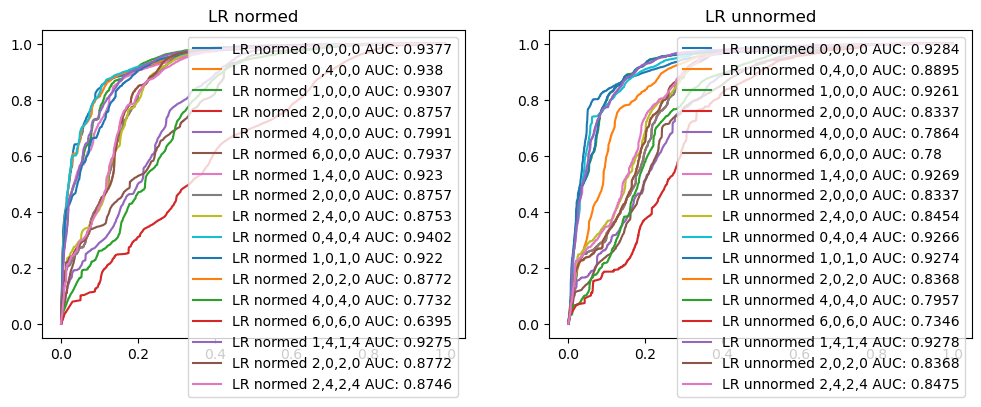

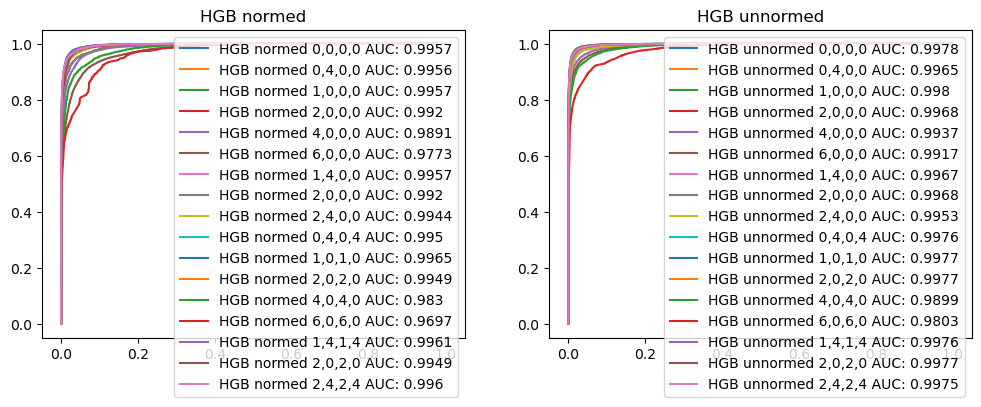

2023-03-22 16:27:02,441 - distributed.worker - ERROR - Exception during execution of task lambda-a61114fe98dea868fc8a74c1aedcfc1b.
Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2390, in _prepare_args_for_execution
    data[k] = self.data[k]
  File "/opt/conda/lib/python3.10/site-packages/distributed/spill.py", line 245, in __getitem__
    return super().__getitem__(key)
  File "/opt/conda/lib/python3.10/site-packages/zict/buffer.py", line 108, in __getitem__
    raise KeyError(key)
KeyError: 'apply_list_of_funcs-df67289e-c500-4aa6-81ec-4ea70dc56e08'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2271, in execute
    args2, kwargs2 = self._prepare_args_for_execution(ts, args, kwargs)
  File "/opt/conda/lib/python3.10/site-packages/distributed/worker.py", line 2394, in _prepare_args_for_exe

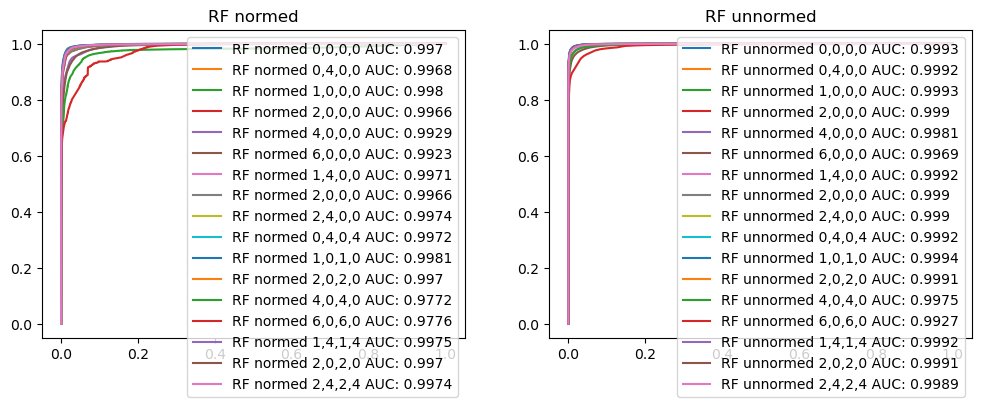

2023-03-22 18:15:10,752 - distributed.nanny - WARNING - Restarting worker
2023-03-22 18:15:10,926 - distributed.nanny - WARNING - Restarting worker


In [22]:
from sklearn import metrics
import matplotlib.pyplot as plt

results_df = pd.read_feather(f"cached/p1.{p1version}.p2.{p2version}.ft")

# plt.figure(0).clf()

for model in models:
    fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
    for i, norm in enumerate([True, False]):
        for index, row in results_df[
            (results_df["model"] == model) & (results_df["normed"] == norm)
        ].iterrows():
            axs[i].plot(
                row["fpr"],
                row["tpr"],
                label=f"{row['model']} {'normed' if row['normed'] else 'unnormed'} {','.join([str(i) for i in row['skips_and_weights']])} AUC: {row['test_data_auc']}",
            )

        axs[i].legend()
        axs[i].set_title(f"{model} {'normed' if norm else 'unnormed'}")
    plt.show()